In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [3]:
# Load the dataset
df = pd.read_csv('/Users/bonnie/Desktop/A New Career/CareerFoundry/Data Immersion/A6_Dashboard/Air_Traffic_Analysis/02 Data/Prepared Data/Air_Traffic_Pax_v3.csv')

### Data Exploration before linear regression model

In [4]:
# Define a mapping from month names to month numbers
month_mapping = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# Convert the 'Month' column to integers using the mapping
df['Month'] = df['Month'].map(month_mapping)

# Check output
df['Month'].value_counts()

Month
8     2432
7     2430
9     2425
6     2425
10    2419
5     2418
11    2398
4     2393
1     2393
12    2393
2     2383
3     2375
Name: count, dtype: int64

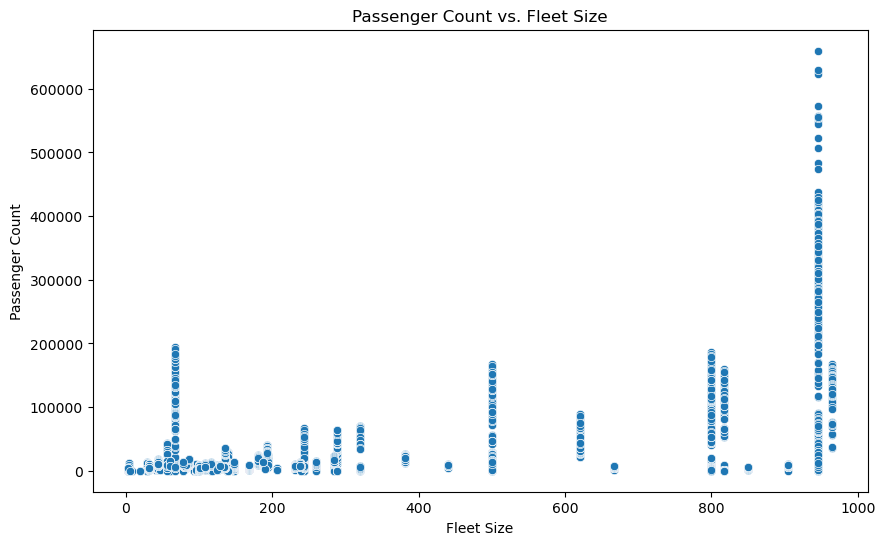

<Figure size 640x480 with 0 Axes>

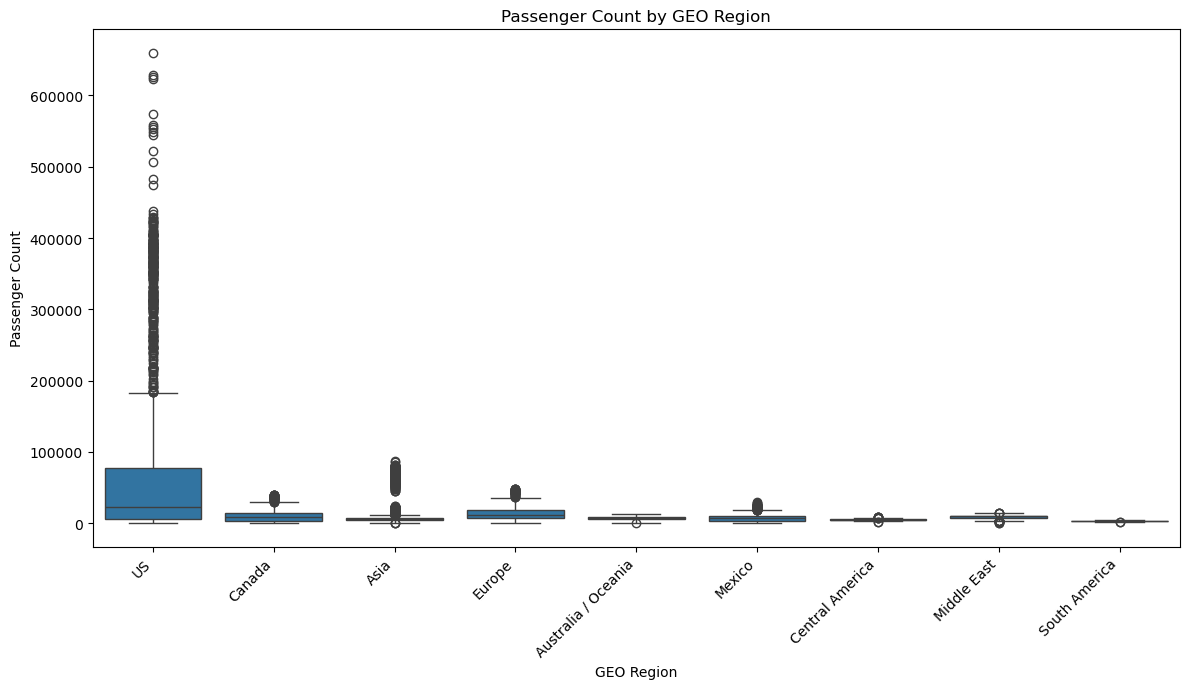

<Figure size 640x480 with 0 Axes>

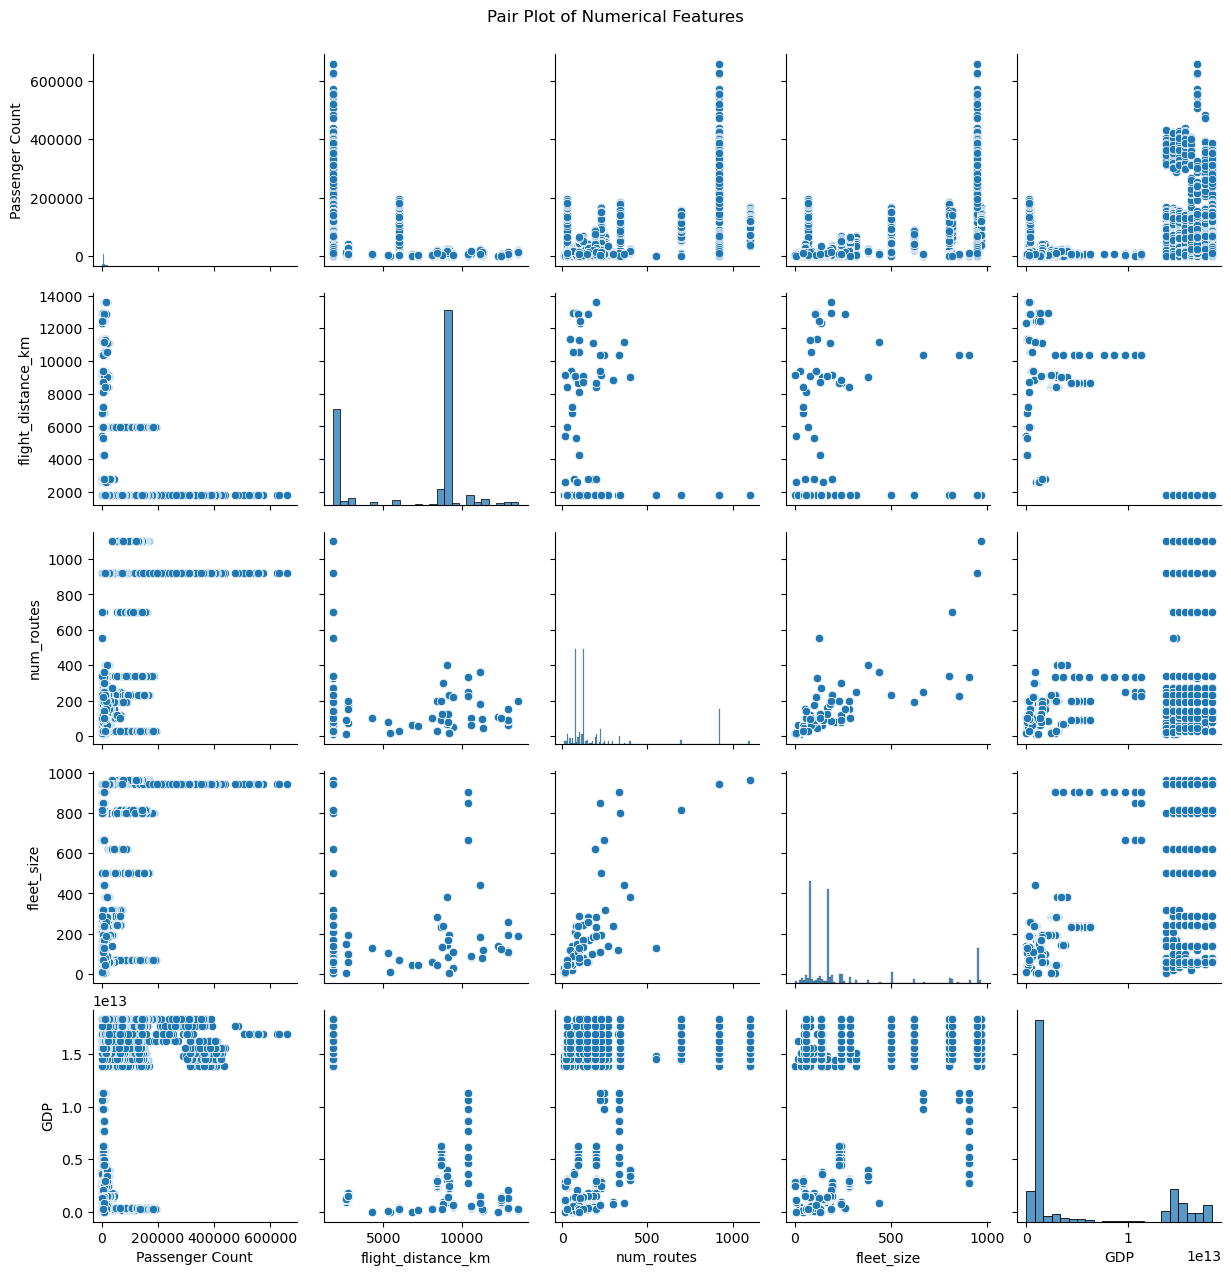

<Figure size 640x480 with 0 Axes>

In [5]:
# 1. Scatterplot: Passenger Count vs. fleet_size
plt.figure(figsize=(10, 6))
sns.scatterplot(x='fleet_size', y='Passenger Count', data=df)
plt.title('Passenger Count vs. Fleet Size')
plt.xlabel('Fleet Size')
plt.ylabel('Passenger Count')
plt.ticklabel_format(style='plain', axis='both')
plt.show()
plt.savefig('passenger_count_vs_fleet_size_scatter.png')


# 2. Box plot: Passenger Count vs. GEO Region
plt.figure(figsize=(12, 7))
sns.boxplot(x='GEO Region', y='Passenger Count', data=df)
plt.title('Passenger Count by GEO Region')
plt.xlabel('GEO Region')
plt.ylabel('Passenger Count')
plt.xticks(rotation=45, ha='right')
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()
plt.savefig('passenger_count_vs_geo_region_boxplot.png')


# 3. Pair plot for key numerical features
# Create a new DataFrame with a subset of columns for the pair plot
numerical_features = ['Passenger Count', 'flight_distance_km', 'num_routes', 'fleet_size', 'GDP']
pair_plot_df = df[numerical_features]

# Create the pair plot
sns.pairplot(pair_plot_df)
plt.suptitle('Pair Plot of Numerical Features', y=1.02)
plt.show()
plt.savefig('numerical_features_pairplot.png')


In [6]:
# Define a consistent set of features
selected_features = [
    'Flight Type', 'GEO Region', 'Activity Type', 'Price Category',
    'Terminal', 'Boarding Area', 'Year', 'Month',
    'flight_distance_km', 'num_routes', 'fleet_size', 'GDP' ]

In [7]:
# Data preparation 
results = {}

# Define the preprocessing steps
categorical_features = ['Flight Type', 'GEO Region', 'Activity Type', 'Price Category', 'Terminal', 'Boarding Area']
numerical_features = ['Year', 'Month', 'flight_distance_km', 'num_routes', 'fleet_size', 'GDP']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Pipeline with preprocessor and Linear Regression
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', LinearRegression())])

### Scenario 1: Keep outliers, NO log transformation

In [10]:
print("Training Model 1: Full data, no log transform...")
X1 = df[selected_features]
y1 = df['Passenger Count']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)
model_pipeline.fit(X_train1, y_train1)
y_pred1 = model_pipeline.predict(X_test1)

results['Model 1'] = {
    'R2': r2_score(y_test1, y_pred1),
    'MSE': mean_squared_error(y_test1, y_pred1),
    'RMSE': np.sqrt(mean_squared_error(y_test1, y_pred1)),
    'MAE': mean_absolute_error(y_test1, y_pred1)
}

Training Model 1: Full data, no log transform...


### Scenario 2: Remove ouliers,NO log transformation

In [11]:
# Outlier Removal Function for Scenario 2 ---
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]


# Train data for scenario 2
print("Training Model 2: Outliers removed, no log transform...")
df_filtered = remove_outliers_iqr(df, 'Passenger Count')
X2 = df_filtered[selected_features]
y2 = df_filtered['Passenger Count']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)
model_pipeline.fit(X_train2, y_train2)
y_pred2 = model_pipeline.predict(X_test2)

results['Model 2'] = {
    'R2': r2_score(y_test2, y_pred2),
    'MSE': mean_squared_error(y_test2, y_pred2),
    'RMSE': np.sqrt(mean_squared_error(y_test2, y_pred2)),
    'MAE': mean_absolute_error(y_test2, y_pred2)
}


Training Model 2: Outliers removed, no log transform...


### Scenario 3: Keep outliers, apply log transformation

In [12]:
# --- Scenario 3: Keep outliers, APPLY log transformation ---
print("Training Model 3: Full data, with log transform...")
df['Passenger Count_log'] = np.log1p(df['Passenger Count'])
X3 = df[selected_features]
y3 = df['Passenger Count_log']

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=42)
model_pipeline.fit(X_train3, y_train3)
y_pred3_log = model_pipeline.predict(X_test3)

# Inverse transform for evaluation on original scale
y_pred3 = np.expm1(y_pred3_log)
y_test3_original = np.expm1(y_test3)

results['Model 3'] = {
    'R2': r2_score(y_test3_original, y_pred3),
    'MSE': mean_squared_error(y_test3_original, y_pred3),
    'RMSE': np.sqrt(mean_squared_error(y_test3_original, y_pred3)),
    'MAE': mean_absolute_error(y_test3_original, y_pred3)
}

Training Model 3: Full data, with log transform...


### Summary Comparison

In [13]:
print("\n--- Summary of Linear Regression Models ---")
summary_df = pd.DataFrame(results).T
print(summary_df.to_markdown(numalign="left", stralign="left"))


--- Summary of Linear Regression Models ---
|         | R2       | MSE         | RMSE    | MAE     |
|:--------|:---------|:------------|:--------|:--------|
| Model 1 | 0.512505 | 8.72608e+08 | 29539.9 | 13967.1 |
| Model 2 | 0.265725 | 5.53336e+06 | 2352.31 | 1670.36 |
| Model 3 | 0.509005 | 8.78873e+08 | 29645.8 | 9453.02 |


##### Detailed Comparison and Analysis

**Model (1): Keep Outliers, No Log Transformation**

This model achieved a moderate R-squared value, explaining about 51% of the variance in passenger count. However, its high MAE and RMSE indicate that its predictions often have a large average error. This is because the model is heavily influenced by the large passenger count values (outliers), which pull the regression line upwards to a place that fits the majority of the data poorly.

**Model (2): Remove Outliers, No Log Transformation**

This model's performance shows a significant trade-off. By removing outliers, the model's MAE and RMSE drastically improved, indicating that its predictions for the remaining data are much more accurate on average. However, the R-squared value dropped considerably. This is because the outliers contained a large portion of the total variance, and by removing them, the model's ability to explain the variance in the remaining data was greatly reduced. This approach is only useful if you want to predict typical passenger counts and are willing to discard data for high-volume flights.

**Model (3): Keep Outliers, Apply Log Transformation**

This model offers the best balance of performance. Its R-squared value is similar to Model (1), meaning it explains a significant amount of the total variance in the dataset. More importantly, its MAE is significantly lower than that of Model (1). This is a result of the log transformation, which effectively compresses the large passenger count values. This reduces their undue influence on the model, allowing it to find a better fit for all data points, including the outliers.

**Conclusion**: The log transformation approach (Model 3) is the best choice among these three. It allows you to build a model that is both accurate across the entire dataset (including high-volume flights) and has a lower prediction error compared to a simple linear model. This method is superior to simply removing outliers because it retains all of the data while mitigating the negative effects of the skewed distribution.


**Potential Hypothesis**

The hypothesis that can be answered by the chosen model is:

The logarithm of a flight's passenger count has a strong positive linear relationship with an airline's fleet size and number of routes, while being significantly influenced by categorical factors such as the flight's geographical region, activity type, and the time of year.

This hypothesis can be tested by examining the R-squared value and the coefficients of the final model. A high R-squared suggests that the linear relationship holds, and the coefficients for fleet_size, num_routes, and the categorical features would show the direction and magnitude of their impact on the passenger count.

**Suggested Better Machine Learning Models**

While linear regression with a log transformation is a strong baseline, the data's inherent complexity and non-linear relationships can be better captured by other models. I would suggest using ensemble methods, which are designed to handle such complexities:

Random Forest Regressor: This model builds multiple decision trees and averages their predictions. It's excellent at capturing complex, non-linear relationships and is less sensitive to outliers, making it a powerful choice.

Gradient Boosting Regressor (e.g., XGBoost, LightGBM): These models build trees sequentially, with each new tree correcting the errors of the previous ones. They often provide state-of-the-art performance on structured, tabular data like this and are highly effective for capturing intricate patterns.